In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file. 

This notebook demonstrates how to do a basic analysis using SMAP data. Specifically, we will:
* Compare the previous year's soil moisture for a region of interest

# How to analyze SMAP data using PODPAC
* Make sure you have PODPAC properly installed WITH the **datatype** optional dependencies: `pip install podpac[datatype]`

In [2]:
import podpac  # This line imports the podpac library into Python

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


## Create the PODPAC Processing Pipeline
* Look at the difference in soil moisture for the same date compared to the previous year:


1. Need to create the SMAP node to access SMAP data from NSIDC
2. Need to offset the user's requested coordinates
3. Need to specify an algorithm

In [4]:
# Create the SMAP node
product = 'SPL4SMAU'   # Level 4 soil moisture analysis update
sm = podpac.datalib.SMAP(product=product, username=username, password=password, cache_type='disk')

In [5]:
# Offset the time from the requested time for the second node
# Note, ExpandCoordinates can be used to specify a range, we're using it to offset the time
sm_time1_offset = podpac.algorithm.ExpandCoordinates(source=sm,
                                                     time=['-1,Y', '-1,Y']  # [start_offset, end_offset]
                                                    )

# ExpandCoordinates is designed to work with a Reduction Node to work properly in a pipeline. 
# Use the "Mean" node to remove time from this Node so that xarray won't try to align the time dimensions
sm_offset = podpac.algorithm.Mean(source=sm_time1_offset, dims=['time'])

# Create the difference algorithm using an existing PODPAC Node
diff = podpac.algorithm.Arithmetic(
          eqn='B-A',   # Specify point-wise operation between datasets (+, -, *, /, sin, cos, exp, ...) 
          A=sm,        # Specify the input for the "A" variable
          B=sm_offset, # Specify the input for the "B" variable
          cache_type='disk'
)

# Create PODPAC Coordinates
* This specifies the region and date where the pipeline will be evaluated

In [6]:
# Specify region of interest on a uniform grid
lat = podpac.crange(  60,  10, -2.0)  # (start, stop, step)
lon = podpac.crange(-130, -60,  2.0)  # (start, stop, step)

# Specify date and time
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
coords = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

# Evaluate the PODPAC Pipeline and plot 
* Retrieve subset of data needed from NSIDC
* Interpolate the data onto the requested grid
* Perform the user-requested operation (B-A)

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2017.05.19/SMAP_L4_SM_aup_20170519T120000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[106:1:671][535:1:1285]


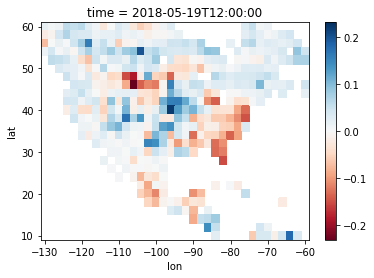

In [7]:
# Evaluate nodes
diff_output = diff.eval(coords)
# Plot the resulting differences
diff_output.plot(cmap='RdBu')

# Examine the PODPAC Pipeline
* This text-based definition is automatically created
* It can be used to share or recreate the pipeline

In [8]:
print(diff.json_pretty)

{
    "nodes": {
        "SMAP_SPL4SMAU": {
            "node": "datalib.smap.SMAP",
            "attrs": {
                "base_url": "https://n5eil02u.ecs.nsidc.org/opendap/SMAP",
                "product": "SPL4SMAU",
                "version": 4
            },
            "interpolation": null
        },
        "ExpandCoordinates": {
            "node": "core.algorithm.coord_select.ExpandCoordinates",
            "attrs": {
                "alt": [],
                "lat": [],
                "lon": [],
                "time": [
                    "-1,Y",
                    "-1,Y"
                ]
            },
            "inputs": {
                "coordinates_source": "SMAP_SPL4SMAU",
                "source": "SMAP_SPL4SMAU"
            }
        },
        "Mean": {
            "node": "core.algorithm.stats.Mean",
            "attrs": {
                "dims": [
                    "time"
                ]
            },
            "inputs": {
                "source":